# Forecasting the Breeding Bird Survey

In [1]:
library(forecast)
library(Hmisc)
library(dplyr)
library(broom)
library(MODISTools)
library(ggplot2)
library(wesanderson)
library(RColorBrewer)
library(tidyr)
source("forecast-bbs-core.R")

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: timeDate
This is forecast 6.1 

Loading required package: grid
Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, round.POSIXt, trunc.POSIXt, units


Attaching package: ‘dplyr’

The following objects are masked from ‘package:Hmisc’:

    combine, src, summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Initial data setup

Load the BBS data and limit it to sites with contiguous time-series from 2000 to 2014 (the range spanned by the MODIS data).

In [2]:
data <- get_bbs_data()
data <- filter(data, (site_id %/% 1000) != 3) # Drop Alaska from analysis
min_ts_length <- 20
contig_ts_long <- get_filtered_ts(data, min_ts_length = min_ts_length)
head(contig_ts_long)

Joining by: "site_id"


,site_id,lat,long,year,species_id,abundance
1,2007,34.86804,-86.20304,1974,2010,1
2,2007,34.86804,-86.20304,1974,2730,4
3,2007,34.86804,-86.20304,1974,2890,24
4,2007,34.86804,-86.20304,1974,3131,2
5,2007,34.86804,-86.20304,1974,3160,48
6,2007,34.86804,-86.20304,1974,3250,10


## Extract the richness time-series

In [3]:
data_by_site_yr <- group_by(contig_ts_long, site_id, year)
richness <- summarise(data_by_site_yr, richness = n_distinct(species_id))
head(richness)

,site_id,year,richness
1,2007,1974,52
2,2007,1978,55
3,2007,1979,59
4,2007,1980,54
5,2007,1981,56
6,2007,1982,44


In [4]:
richness_by_site <- group_by(richness, site_id)
cat("There are", n_groups(richness_by_site), "continuous time-series with at least" , min_ts_length, "years of data")

There are 888 continuous time-series with at least 20 years of data

## NDVI time-series data

In [5]:
data_modern <- filter(data, year >= 2000)
contig_ts_long_modern <- get_filtered_ts(data_modern, min_ts_length = 15)
richness_w_ndvi <- get_ndvi_ts_data(contig_ts_long_modern, modis_data_location = "./data/modisdata/100kmsq/")
head(richness_w_ndvi)
richness_w_ndvi_by_site <- group_by(richness_w_ndvi, site_id)

Joining by: "site_id"


,site_id,lat,long,year,richness,start.date,end.date,SubsetID,ndvi
1,2001,34.86869,-87.60414,2000,61,2000-06-01,2000-06-30,Lat34.86869Lon-87.60414Start2000-06-01End2000-06-30,0.6786047
2,2001,34.86869,-87.60414,2001,58,2001-06-01,2001-06-30,Lat34.86869Lon-87.60414Start2001-06-01End2001-06-30,0.7272236
3,2001,34.86869,-87.60414,2002,61,2002-06-01,2002-06-30,Lat34.86869Lon-87.60414Start2002-06-01End2002-06-30,0.6786379
4,2001,34.86869,-87.60414,2003,66,2003-06-01,2003-06-30,Lat34.86869Lon-87.60414Start2003-06-01End2003-06-30,0.7335131
5,2001,34.86869,-87.60414,2004,62,2004-06-01,2004-06-30,Lat34.86869Lon-87.60414Start2004-06-01End2004-06-30,0.753227
6,2001,34.86869,-87.60414,2005,59,2005-06-01,2005-06-30,Lat34.86869Lon-87.60414Start2005-06-01End2005-06-30,0.7385954


## Forecasting

Generate forecasts for naive, average, and ARIMA time-series models for each site.

In [6]:
lag <- 5
tsmodel_forecasts <- get_ts_forecasts(richness_by_site, timecol = 'year',
                                      responsecol = 'richness', lag = lag)
tsmodel_forecasts_modern <- get_ts_forecasts(richness_w_ndvi_by_site,
                                             timecol = 'year',
                                             responsecol = 'richness',
                                             lag = lag)
head(tsmodel_forecasts_modern, 1)

,site_id,year,cast_naive,cast_avg,cast_arima,test_set
1,2001,"2010, 2011, 2012, 2013, 2014","Naive method, 12.33333, -24.07582, 50.15164, 0, 0, 0, 0, 1, 1, 0, 0.06099997, -3, 3, 5, -4, -3, 5, 0, -3, -3, Arima(x = x, order = c(0, 1, 0), lambda = lambda), x, 0, 0, 9, 1, 1, 1, -3, 61, 0, 7.420876e-23, 7.420876e-23, -7.420876e-23, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, -7.420876e-23, 50.72307, 50.34887, 61, 58, 61, 66, 62, 59, 64, 64, 61, 58, 80, 95, 58, 58, 58, 58, 58, 53.49934, 51.6351, 50.20463, 48.99868, 47.93622, 51.11683, 48.26573, 46.078, 44.23367, 42.60877, 62.50066, 64.3649, 65.79537, 67.00132, 68.06378, 64.88317, 67.73427, 69.922, 71.76633, 73.39123, 61, 58, 61, 66, 62, 59, 64, 64, 61, 58, structure(c(61L, 58L, 61L, 66L, 62L, 59L, 64L, 64L, 61L, 58L), .Tsp = c(1, , 10, 1), class = ""ts""), NA, 61, 58, 61, 66, 62, 59, 64, 64, 61, NA, -3, 3, 5, -4, -3, 5, 0, -3, -3","Mean, 80, 95, 61, 58, 61, 66, 62, 59, 64, 64, 61, 58, .[[responsecol]][1:(length(.[[responsecol]]) - lag)], 61.4, 61.4, 61.4, 61.4, 61.4, 57.51984, 57.51984, 57.51984, 57.51984, 57.51984, 55.0534, 55.0534, 55.0534, 55.0534, 55.0534, 65.28016, 65.28016, 65.28016, 65.28016, 65.28016, 67.7466, 67.7466, 67.7466, 67.7466, 67.7466, 61.4, 0.8459052, 2.674987, meanf(x = .[[responsecol]][1:(length(.[[responsecol]]) - lag)], , h = lag), 61.4, 61.4, 61.4, 61.4, 61.4, 61.4, 61.4, 61.4, 61.4, 61.4, -0.4, -3.4, -0.4, 4.6, 0.6, -2.4, 2.6, 2.6, -0.4, -3.4","ARIMA(0,0,0) with non-zero mean, 61.4, 6.44, 0.6440073, TRUE, -23.50203, 51.00406, 0, 0, 0, 0, 1, 0, 0, -0.4, -3.4, -0.4, 4.6, 0.6, -2.4, 2.6, 2.6, -0.4, -3.4, auto.arima(x = structure(list(x = structure(c(61L, 58L, 61L, , 66L, 62L, 59L, 64L, 64L, 61L, 58L), .Tsp = c(1, 10, 1), class = ""ts"")), .Names = ""x"", row.names = c(NA, , -10L), class = ""data.frame""), seasonal = FALSE), .[[responsecol]][1:(length(.[[responsecol]]) - lag)], 0, 0, 10, 1, -3.4, 0, 0, 1, 0, 1, 51.60923, 52.71834, 61, 58, 61, 66, 62, 59, 64, 64, 61, 58, 80, 95, 61.4, 61.4, 61.4, 61.4, 61.4, 58.14779, 58.14779, 58.14779, 58.14779, 58.14779, 56.42617, 56.42617, 56.42617, 56.42617, 56.42617, 64.65221, 64.65221, 64.65221, 64.65221, 64.65221, 66.37383, 66.37383, 66.37383, 66.37383, 66.37383, 61, 58, 61, 66, 62, 59, 64, 64, 61, 58, structure(c(61L, 58L, 61L, 66L, 62L, 59L, 64L, 64L, 61L, 58L), .Tsp = c(1, , 10, 1), class = ""ts""), 61.4, 61.4, 61.4, 61.4, 61.4, 61.4, 61.4, 61.4, 61.4, 61.4, -0.4, -3.4, -0.4, 4.6, 0.6, -2.4, 2.6, 2.6, -0.4, -3.4","61, 69, 59, 69, 69"


## NDVI based forecasting


Call:
lm(formula = meanrich ~ meanndvi, data = richness_w_ndvi_site_avg)

Residuals:
    Min      1Q  Median      3Q     Max 
-30.729  -6.784  -0.452   5.932  41.776 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   30.556      1.602   19.07   <2e-16 ***
meanndvi      40.199      2.314   17.37   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.45 on 628 degrees of freedom
  (6 observations deleted due to missingness)
Multiple R-squared:  0.3245,	Adjusted R-squared:  0.3234 
F-statistic: 301.7 on 1 and 628 DF,  p-value: < 2.2e-16


Warning message:
: Removed 6 rows containing missing values (stat_smooth).Warning message:
: Removed 6 rows containing missing values (geom_point).

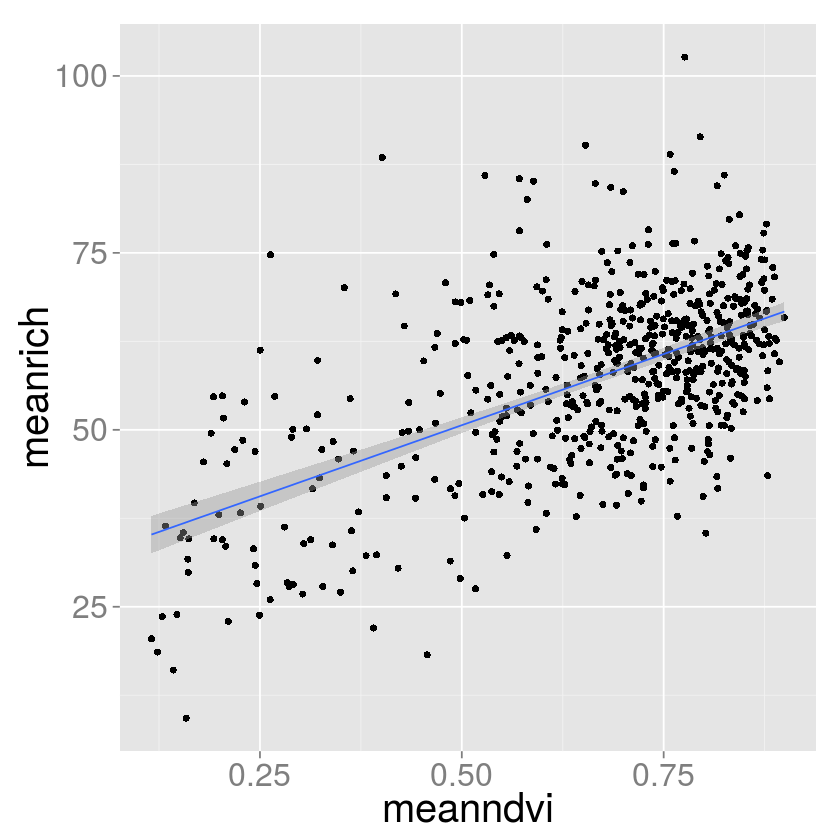

In [7]:
richness_w_ndvi_by_site <- group_by(richness_w_ndvi, site_id)
richness_w_ndvi_site_avg <- summarize(richness_w_ndvi_by_site, meanrich = mean(richness), meanndvi = mean(ndvi))
summary(lm(meanrich ~ meanndvi, data = richness_w_ndvi_site_avg))
ggplot(richness_w_ndvi_site_avg, aes(x = meanndvi, y = meanrich)) +
       geom_point() +
       geom_smooth(method = 'lm') +
       theme_grey(base_size = 24)

In [8]:
richness_w_ndvi_by_year <- group_by(richness_w_ndvi, year)
results <- richness_w_ndvi_by_year %>%
           do(fitndvi = lm(richness ~ ndvi, data = .))
ndvi_spatial_models <- tidy(results, fitndvi)
ndvi_spatial_fits <- glance(results, fitndvi)

## Spatial NDVI model prediction

In [9]:
richness_w_ndvi_2008 <- filter(richness_w_ndvi, year == 2008)
richness_w_ndvi_2009 <- filter(richness_w_ndvi, year == 2009)
richness_w_ndvi_2009 <- cbind(richness_w_ndvi, last_yr_rich = richness_w_ndvi_2008$richness)
richness_w_ndvi_2010_2014 <- filter(richness_w_ndvi, year >= 2010)
spatial_ndvi_model_2009 <- lm(richness ~ ndvi, data = richness_w_ndvi_2009)
fcast_spatial_ndvi <- forecast(spatial_ndvi_model_2009, newdata = richness_w_ndvi_2010_2014)
fcast_spatial_ndvi_data <- cbind(richness_w_ndvi_2010_2014, fcast_spatial_ndvi)
fcast_spatial_ndvi <- fcast_spatial_ndvi_data[, c("site_id", "year", "richness", "Point Forecast", "Lo 80", "Hi 80", "Lo 95", "Hi 95")]
colnames(fcast_spatial_ndvi) <- c("site_id", "year", "obs", "pt_fcast", "lo80", "hi80", "lo95", "hi95")
fcast_spatial_ndvi$model <- 'spat_ndvi'
fcast_spatial_ndvi <- select(fcast_spatial_ndvi, site_id, model, everything())
head(fcast_spatial_ndvi)
spatial_ndvi_fig <- ggplot(richness_w_ndvi_2009, aes(x = ndvi, y = richness)) +
                           geom_point(size = 5) +
                           geom_smooth(method = "lm", size = 1) +
                           labs(x = "NDVI", y = "Richness") +
                           theme_grey(base_size = 36)
ggsave(spatial_ndvi_fig, file = "spatial_ndvi_fig.png")

,site_id,model,year,obs,pt_fcast,lo80,hi80,lo95,hi95
1,2001,spat_ndvi,2010,61,59.62849,44.91789,74.33908,37.12928,82.12769
2,2001,spat_ndvi,2011,69,58.09371,43.38318,72.80423,35.5946,80.59281
3,2001,spat_ndvi,2012,59,55.95576,41.24521,70.66631,33.45662,78.4549
4,2001,spat_ndvi,2013,69,59.65503,44.94443,74.36562,37.15582,82.15424
5,2001,spat_ndvi,2014,69,58.17345,43.46293,72.88398,35.67435,80.67256
6,2021,spat_ndvi,2010,41,62.39968,47.68878,77.11058,39.9,84.89936


Saving 7 x 7 in image
Warning message:
: Removed 6 rows containing missing values (stat_smooth).Warning message:
: Removed 6 rows containing missing values (geom_point).

## Temporal NDVI model prediction

In [10]:
richness_w_ndvi_by_site <- group_by(richness_w_ndvi, site_id)
fcast_temporal_ndvi_data <- richness_w_ndvi_by_site %>% do({
                            trainset <- filter(., year <= 2014 - lag)
                            testset <- filter(., year > 2014 - lag)
                            fitndvi <- lm(richness ~ ndvi, data = trainset)
                            fitndvi$data <- trainset # see http://stackoverflow.com/questions/31399605/passing-data-to-forecast-lm-using-dplyr-and-do
                            data.frame(testset[], fcast = forecast(fitndvi, newdata = testset))})
fcast_temporal_ndvi <- fcast_temporal_ndvi_data[, c("site_id", "year", "richness", "fcast.Point.Forecast", "fcast.Lo.80", "fcast.Hi.80", "fcast.Lo.95", "fcast.Hi.95")]
colnames(fcast_temporal_ndvi) <- c("site_id", "year", "obs", "pt_fcast", "lo80", "hi80", "lo95", "hi95")
fcast_temporal_ndvi$model <- 'temporal_ndvi'
fcast_temporal_ndvi <- select(fcast_temporal_ndvi, site_id, model, everything())
head(fcast_temporal_ndvi)

,site_id,model,year,obs,pt_fcast,lo80,hi80,lo95,hi95
1,2001,temporal_ndvi,2010,61,61.0506,56.87691,65.22429,54.16025,67.94095
2,2001,temporal_ndvi,2011,69,61.68561,57.543,65.82822,54.84656,68.52465
3,2001,temporal_ndvi,2012,59,62.57017,57.53262,67.60772,54.25367,70.88667
4,2001,temporal_ndvi,2013,69,61.03962,56.85998,65.21926,54.13944,67.93979
5,2001,temporal_ndvi,2014,69,61.65261,57.5237,65.78153,54.83618,68.46904
6,2021,temporal_ndvi,2010,41,49.35899,39.06246,59.65552,32.36043,66.35755



## Assembling forecasts from different approaches

In [11]:
tsmodel_out <- tsmodel_forecasts_modern %>%
                        do(
                           {year <- as.data.frame(.$year)
                            colnames(year) <- c('year')
                            naive <- as.data.frame(.$cast_naive)
                            colnames(naive) <- c('pt_fcast', 'lo80', 'hi80', 'lo95', 'hi95')
                            naive <- cbind(year, naive)
                            naive$model <- 'naive'
                            naive$site_id <- .$site
                            naive$obs <- .$test_set
                            avg <- as.data.frame(.$cast_avg)
                            colnames(avg) <- c('pt_fcast', 'lo80', 'hi80', 'lo95', 'hi95')
                            avg <-cbind(year, avg)
                            avg$model <- 'avg'
                            avg$site_id <- .$site
                            avg$obs <- .$test_set
                            arima <- as.data.frame(.$cast_arima)
                            colnames(arima) <- c('pt_fcast', 'lo80', 'hi80', 'lo95', 'hi95')
                            arima <- cbind(year, arima)
                            arima$model <- 'arima'
                            arima$site_id <- .$site
                            arima$obs <- .$test_set
                            df <- rbind(naive, avg, arima)
                            df %>% select(site_id, model, year, obs, everything())
                           }
                          )
head(tsmodel_out)

,site_id,model,year,obs,pt_fcast,lo80,hi80,lo95,hi95
1,2001,naive,2010,61,58,53.49934,62.50066,51.11683,64.88317
2,2001,naive,2011,69,58,51.6351,64.3649,48.26573,67.73427
3,2001,naive,2012,59,58,50.20463,65.79537,46.078,69.922
4,2001,naive,2013,69,58,48.99868,67.00132,44.23367,71.76633
5,2001,naive,2014,69,58,47.93622,68.06378,42.60877,73.39123
6,2001,avg,2010,61,61.4,57.51984,65.28016,55.0534,67.7466


In [12]:
forecasts <- rbind(tsmodel_out, fcast_temporal_ndvi, fcast_spatial_ndvi)
head(forecasts)

,site_id,model,year,obs,pt_fcast,lo80,hi80,lo95,hi95
1,2001,naive,2010,61,58,53.49934,62.50066,51.11683,64.88317
2,2001,naive,2011,69,58,51.6351,64.3649,48.26573,67.73427
3,2001,naive,2012,59,58,50.20463,65.79537,46.078,69.922
4,2001,naive,2013,69,58,48.99868,67.00132,44.23367,71.76633
5,2001,naive,2014,69,58,47.93622,68.06378,42.60877,73.39123
6,2001,avg,2010,61,61.4,57.51984,65.28016,55.0534,67.7466


In [13]:
model_accuracies <- group_by(forecasts, site_id, model) %>%
                    do(get_error_measures(.$obs, .$pt_fcast))
head(model_accuracies)

Warning message:
: Grouping rowwise data frame strips rowwise nature

,site_id,model,ME,RMSE,MAE,MPE,MAPE
1,2001,arima,4,5.986652,5.12,5.663989,7.553403
2,2001,avg,4,5.986652,5.12,5.663989,7.553403
3,2001,naive,7.4,8.637129,7.4,10.88781,10.88781
4,2001,spat_ndvi,7.098713,8.180932,7.098713,10.48968,10.48968
5,2001,temporal_ndvi,3.800278,6.059716,5.248586,5.330331,7.783966
6,2021,arima,3.2,5.865151,5.2,6.829097,13.72565


In [42]:
cbPalette <- c("#F0E442", "#D55E00", "#E69F00", "#56B4E9", "#009E73", "#0072B2", "#999999", "#CC79A7")
# rearranged from http://www.cookbook-r.com/Graphs/Colors_%28ggplot2%29/#a-colorblind-friendly-palette

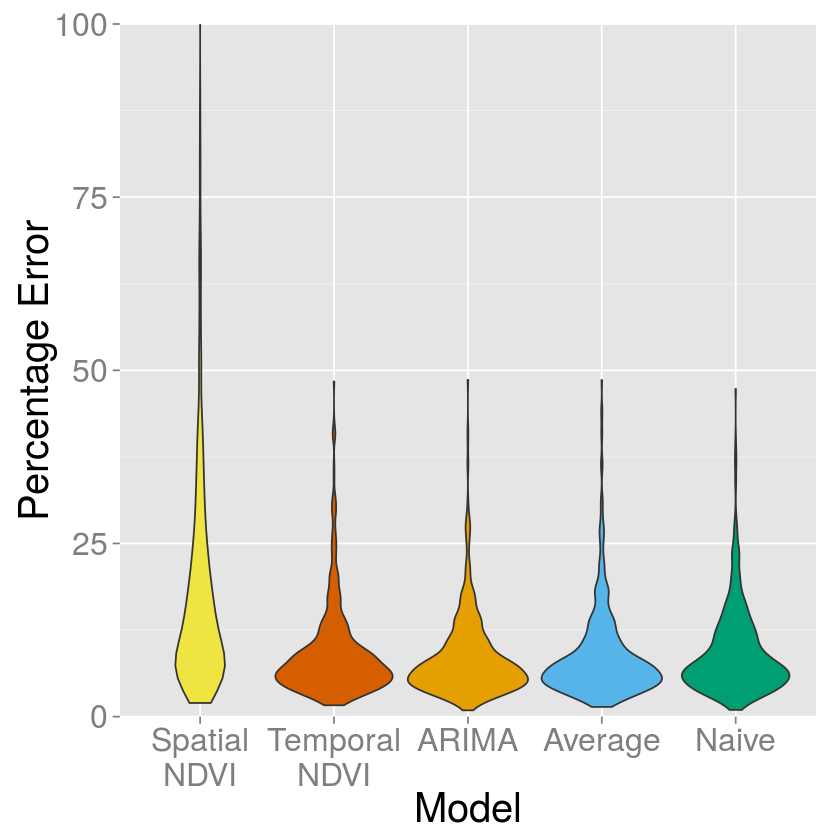

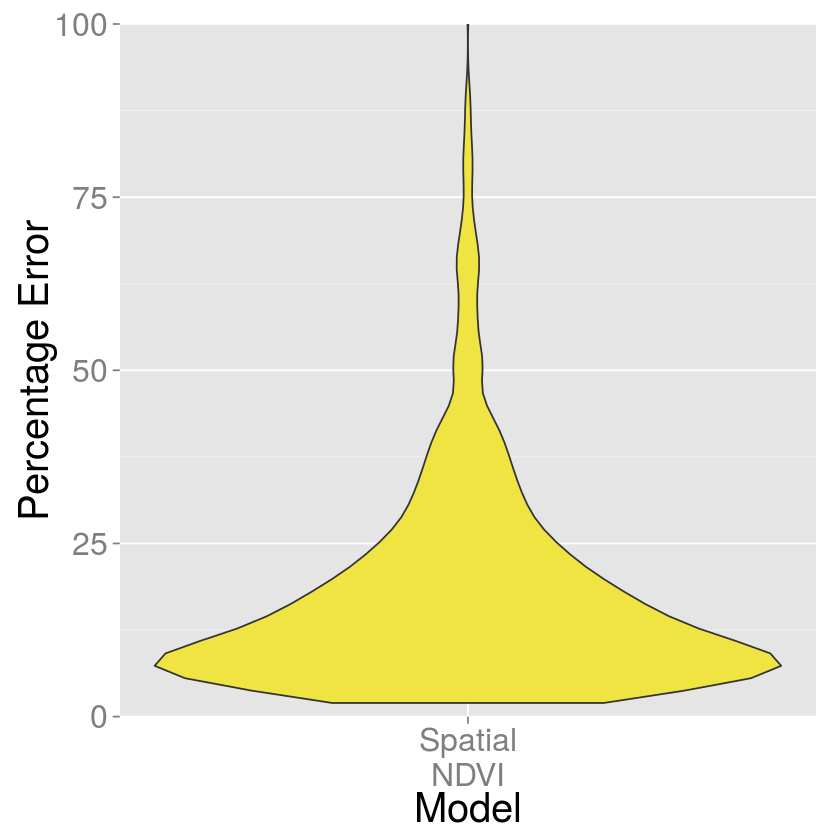

In [45]:
model_accuracies$model = with(model_accuracies, factor(model, levels = c("spat_ndvi", "temporal_ndvi", "arima", "avg", "naive")))
accuracy_by_model_violins <- ggplot(model_accuracies, aes(model, MAPE)) +
     geom_violin(aes(fill = model)) + coord_cartesian(ylim = c(0,100)) +
     labs(x = "Model", y = "Percentage Error") +
     scale_x_discrete(labels=c("Spatial\nNDVI", "Temporal\nNDVI", "ARIMA", "Average", "Naive")) +
     scale_fill_manual(values = cbPalette) + 
     theme_grey(base_size = 24) +
     guides(fill=FALSE)
ggsave(accuracy_by_model_violins, file = 'accuracy_by_model_violins.png', width = 7, height = 5)
accuracy_by_model_violins

In [51]:

accuracy_by_model_violins_nobenchmodel_accuracies_by_year <- group_by(forecasts, site_id, model, year) %>%
                    do(get_error_measures(.$obs, .$pt_fcast))
model_accuracies_by_year$model = with(model_accuracies_by_year, factor(model, levels = c("spat_ndvi", "temporal_ndvi", "arima", "avg", "naive")))
head(model_accuracies_by_year)

Warning message:
: Grouping rowwise data frame strips rowwise nature

,site_id,model,year,ME,RMSE,MAE,MPE,MAPE
1,2001,arima,2010,-0.4,0.4,0.4,-0.6557377,0.6557377
2,2001,arima,2011,7.6,7.6,7.6,11.01449,11.01449
3,2001,arima,2012,-2.4,2.4,2.4,-4.067797,4.067797
4,2001,arima,2013,7.6,7.6,7.6,11.01449,11.01449
5,2001,arima,2014,7.6,7.6,7.6,11.01449,11.01449
6,2001,avg,2010,-0.4,0.4,0.4,-0.6557377,0.6557377


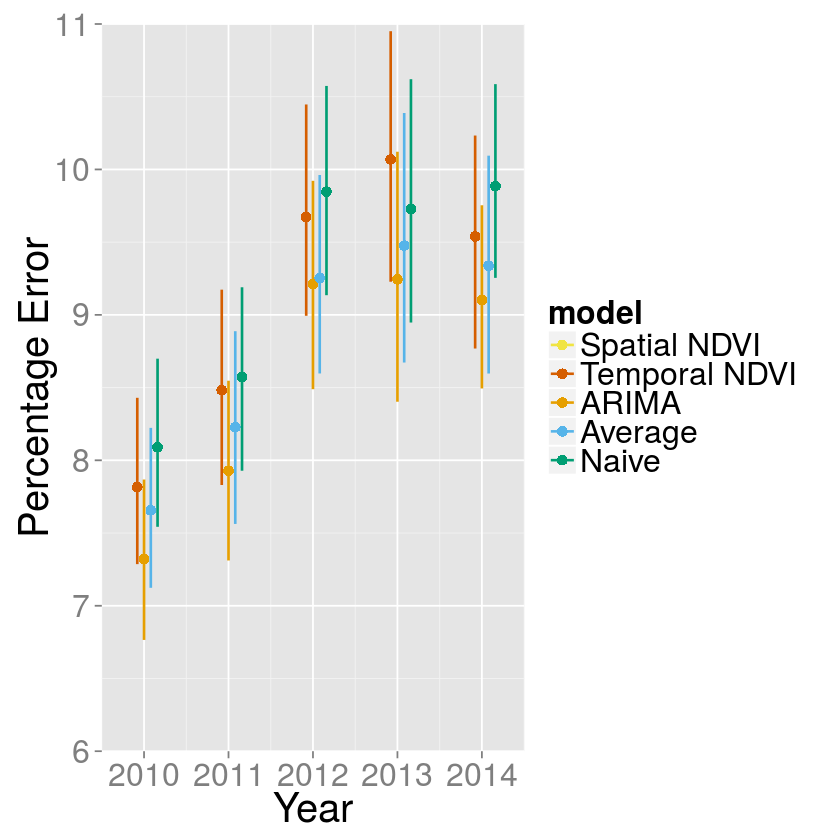

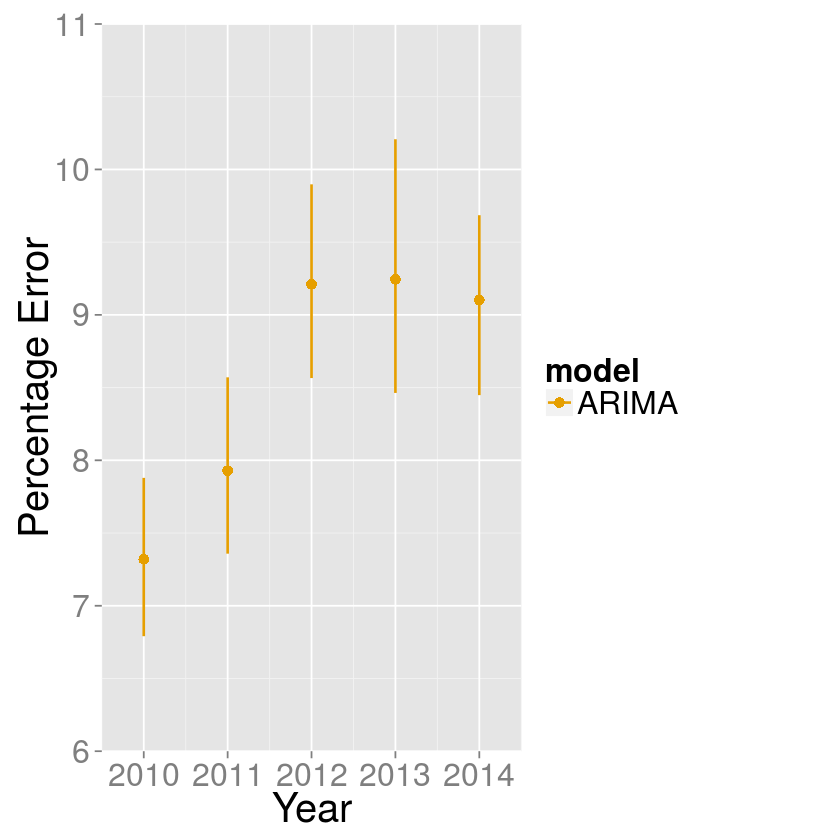

In [58]:
#ggplot(model_accuracies_by_year, aes(x = year, y = MAPE, color = model)) + stat_summary(fun.data = "mean_cl_boot")
model_accuracies_by_year_plot <- ggplot(model_accuracies_by_year, aes(x = year, y = MAPE, color = model)) +
    stat_summary(fun.data = "mean_cl_boot", position=position_dodge(width = 0.4), size=0.75) +
     labs(x = "Year", y = "Percentage Error") +
     coord_cartesian(ylim = c(6,11), xlim = c(2009.5,2014.5)) +
     #scale_color_discrete(labels=c("ARIMA", "Average", "Naive", "Temporal NDVI")) +
     scale_shape_discrete(labels=c("Spatial NDVI", "Temporal NDVI", "ARIMA", "Average", "Naive")) +
     scale_color_manual(values = cbPalette, labels=c("Spatial NDVI", "Temporal NDVI", "ARIMA", "Average", "Naive")) + 
     theme_grey(base_size = 24)
     #theme(legend.justification=c(1,0), legend.position=c(1,0))
ggsave(model_accuracies_by_year_plot, file = "model_accuracies_by_year.png", height = 5, width = 7)

model_accuracies_by_year_arima_plot <- ggplot(filter(model_accuracies_by_year, model == 'arima'), aes(x = year, y = MAPE, color = model, shape = model)) +
     stat_summary(fun.data = "mean_cl_boot", size=0.75, shape = scale_shape_identity(22)) +
     labs(x = "Year", y = "Percentage Error") +
     coord_cartesian(ylim = c(6,11), xlim = c(2009.5,2014.5)) +
     scale_shape_discrete(labels=c("ARIMA             ")) +
     scale_color_manual(values = cbPalette[3], labels=c("ARIMA             ")) + 
     theme_grey(base_size = 24)

ggsave(model_accuracies_by_year_arima_plot, file = "arima_accuracies_by_year.png", height = 5, width = 7)

model_accuracies_by_year_plot
model_accuracies_by_year_arima_plot

## Example single site forecast

,site_id,lat,long,year,richness,start.date,end.date,SubsetID,ndvi
1,27027,34.05453,-84.78686,2010,70,2010-06-01,2010-06-30,Lat34.05453Lon-84.78686Start2010-06-01End2010-06-30,0.7601522
2,27027,34.05453,-84.78686,2011,70,2011-06-01,2011-06-30,Lat34.05453Lon-84.78686Start2011-06-01End2011-06-30,0.7467286
3,27027,34.05453,-84.78686,2012,68,2012-06-01,2012-06-30,Lat34.05453Lon-84.78686Start2012-06-01End2012-06-30,0.7532482
4,27027,34.05453,-84.78686,2013,72,2013-06-01,2013-06-30,Lat34.05453Lon-84.78686Start2013-06-01End2013-06-30,0.7666409
5,27027,34.05453,-84.78686,2014,69,2014-06-01,2014-06-30,Lat34.05453Lon-84.78686Start2014-06-01End2014-06-30,0.7784055


Saving 7 x 7 in image


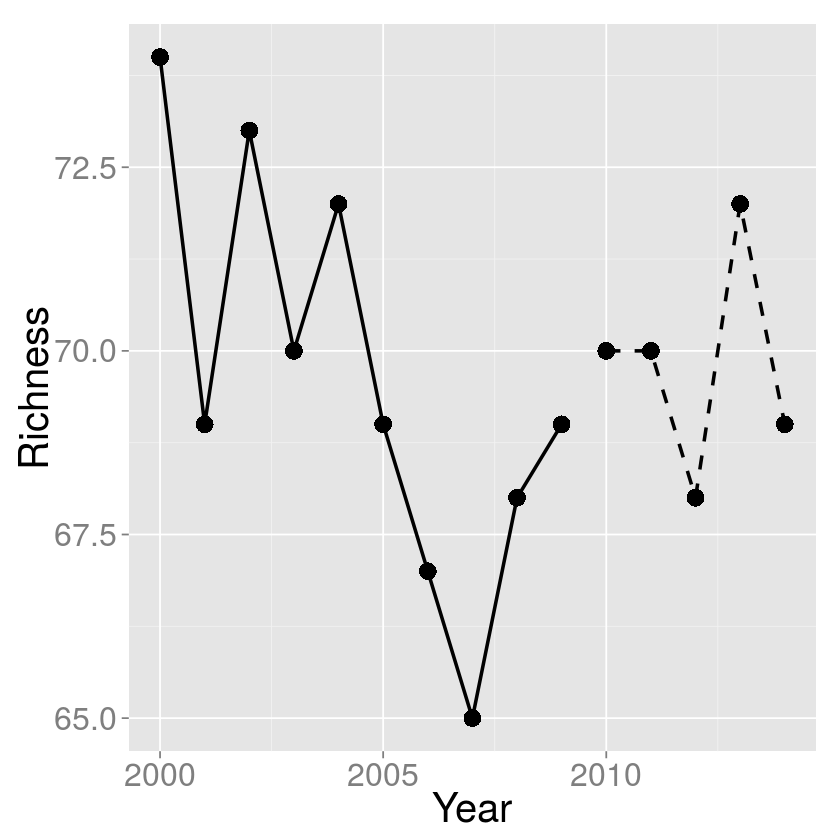

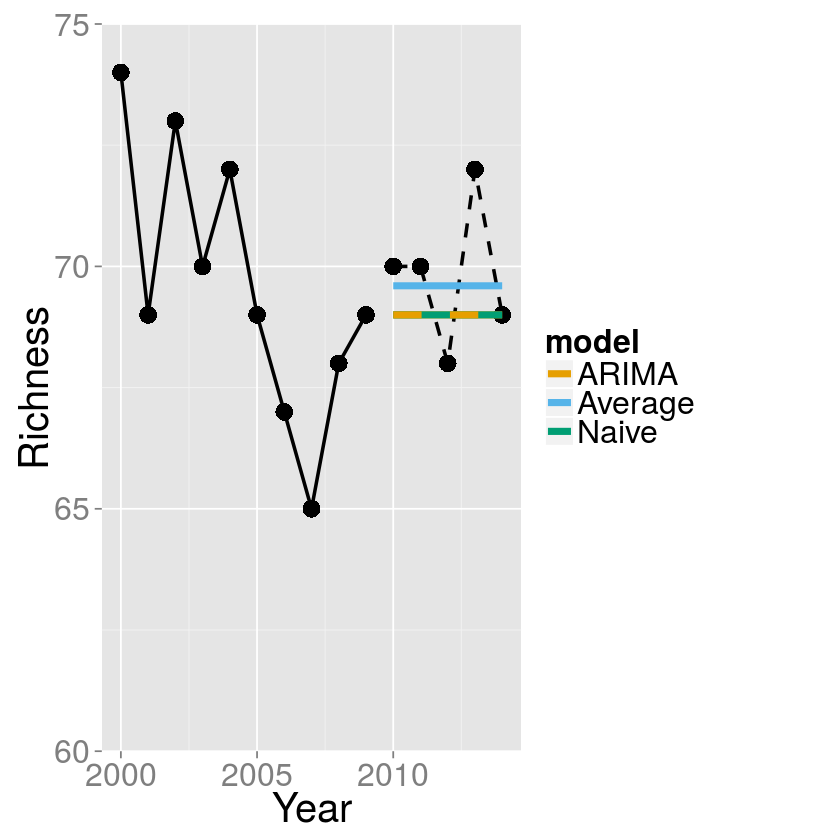

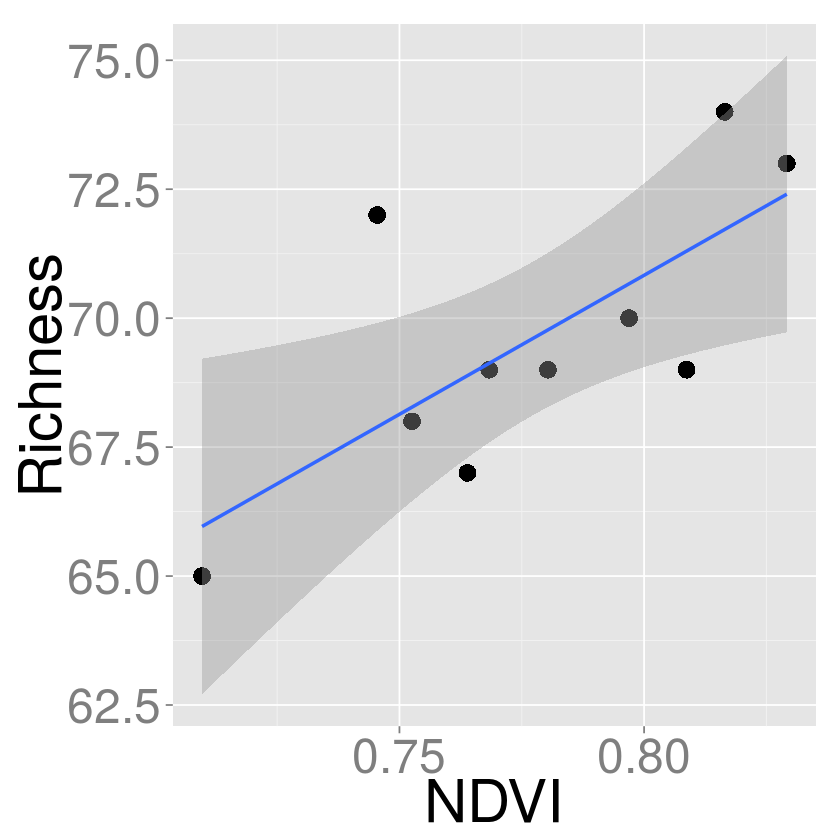

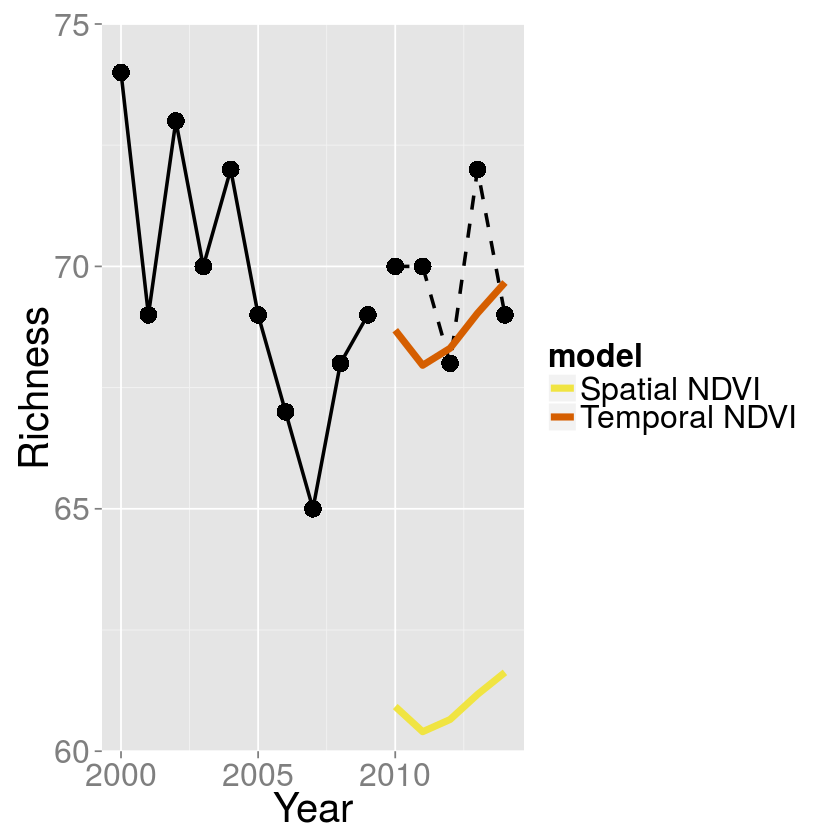

In [60]:
focal_data <- richness_w_ndvi
sites <- unique(focal_data$site_id)
focal_site <- sites[125]
forecasts_focal <- filter(forecasts, site_id == focal_site)
forecasts_ts <- filter(forecasts_focal, model %in% c('arima', 'avg', 'naive'))
forecasts_ndvi <- filter(forecasts_focal, model %in% c('spat_ndvi', 'temporal_ndvi'))
train_set <- filter(focal_data, site_id == focal_site, year < 2010)
test_set <- filter(focal_data, site_id == focal_site, year >= 2010)
head(test_set)

examp_ts <- ggplot(train_set, aes(year, richness)) +
  geom_point(size = 5) +
  geom_line(size = 1) +
  geom_point(data = test_set, size = 5) +
  geom_line(data = test_set, size = 1, linetype = "dashed") +
  labs(x = "Year", y = "Richness") +
  theme_grey(base_size = 24)

examp_ts_fcast <- ggplot(train_set, aes(year, richness)) +
  geom_point(size = 5) +
  geom_line(size = 1) +
  geom_point(data = test_set, size = 5) +
  geom_line(data = test_set, size = 1, linetype = "dashed") +
  geom_line(data = forecasts_ts, aes(x = year, y = pt_fcast, color = model), size=2) +
  coord_cartesian(ylim = c(60,75)) +
  scale_color_manual(values = cbPalette[3:5], labels=c("ARIMA             ", "Average", "Naive")) +
  geom_line(data = filter(forecasts_ts, model == "arima"), aes(x = year, y = pt_fcast), color = cbPalette[3], linetype = "dashed", size = 2) +
  labs(x = "Year", y = "Richness") +
  theme_grey(base_size = 24)

examp_temp_ndvi_model <- ggplot(train_set, aes(ndvi, richness)) +
                                geom_point(size = 5) +
                                geom_smooth(method = 'lm', size = 1) +
                                labs(x = "NDVI", y = "Richness") +
                                theme_grey(base_size = 36)

examp_ndvi_fcast <- ggplot(train_set, aes(year, richness)) +
  geom_point(size = 5) +
  geom_line(size = 1) +
  geom_point(data = test_set, size = 5) +
  geom_line(data = test_set, size = 1, linetype = "dashed") +
  geom_line(data = forecasts_ndvi, aes(x = year, y = pt_fcast, color = model), size=2) +
  coord_cartesian(ylim = c(60,75)) +
  scale_color_manual(values = cbPalette[1:2], labels=c("Spatial NDVI", "Temporal NDVI")) +
  labs(x = "Year", y = "Richness") +
  theme_grey(base_size = 24)

ggsave(examp_ts_fcast, file = "examp_ts_fcast.png", height = 5, width = 7)
ggsave(examp_temp_ndvi_model, file = "examp_temp_ndvi_model.png")
ggsave(examp_ndvi_fcast, file = "examp_ndvi_fcast.png", height = 5, width = 7)

examp_ts
examp_ts_fcast
examp_temp_ndvi_model
examp_ndvi_fcast

In [34]:
full_examp_ts <- ggplot(filter(focal_data, site_id == focal_site), aes(x = year, y = richness)) +
       geom_point(size = 10) +
       geom_line(size = 2) +
       labs(x = "Year", y = "Richness") +
       theme_grey(base_size = 40) +
       theme(axis.text.x = element_blank(),axis.text.y=element_blank())

ndvi_examp_ts <- ggplot(filter(focal_data, site_id == focal_site), aes(x = year, y = ndvi)) +
       geom_point(size = 10, color = cbPalette[5]) +
       geom_line(size = 2, color = cbPalette[5]) +
       labs(x = "Year", y = "Environment") +
       theme_grey(base_size = 40) +
       theme(axis.text.x = element_blank(),axis.text.y=element_blank())


full_ndvi_model_examp <- ggplot(filter(focal_data, site_id == focal_site), aes(x = ndvi, y = richness)) +
       geom_point(size = 7) +
       geom_smooth(method = "lm", size = 3) +
       labs(x = "Environment", y = "Richness") +
       theme_grey(base_size = 40) +
       theme(axis.text.x = element_blank(),axis.text.y=element_blank())

spatial_env_model_examp <- ggplot(richness_w_ndvi_site_avg, aes(x = meanndvi, y = meanrich)) +
       geom_point(size = 5) +
       geom_smooth(method = 'lm', size = 3) +
       labs(x = "Environment", y = "Richness") +
       theme_grey(base_size = 40) +
       theme(axis.text.x = element_blank(),axis.text.y=element_blank())

ggsave(full_examp_ts, file = "full_examp_ts.png")
ggsave(ndvi_examp_ts, file = "ndvi_examp_ts.png")
ggsave(full_ndvi_model_examp, file = "full_ndvi_model_examp.png")
ggsave(spatial_env_model_examp, file = "spatial_env_model_examp.png")

Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Warning message:
: Removed 6 rows containing missing values (stat_smooth).Warning message:
: Removed 6 rows containing missing values (geom_point).